In [1]:
import pandas as pd 
import numpy as np 
from simulation import simulation_erlang as sim
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from optimization import optimization as opt

## Simulation - Staffing Levels

In [2]:
# Generate date range for the entire year
start_date = pd.to_datetime("2024-01-01 00:00:00")
end_date = pd.to_datetime("2024-12-31 23:59:59")
date_range = pd.date_range(start_date, end_date, freq='30T')

# Create DataFrame with random demand values
df = pd.DataFrame(index=date_range)


# Extract date and time separately
df['date'] = df.index.date
df['time'] = df.index.time
index_list = df.index.to_list()

df = df.reset_index()

# Apply the function to create a new column
df['shift'] = df.index.to_series().apply(sim.assign_group_number)
df.set_index('index', inplace=True)
df['day'] = 1
df.drop(['date', 'time'], axis=1, inplace=True)
demand_df = df
shift_time_dict = {}
for idx, shift in demand_df.iterrows():
    if shift[0] not in shift_time_dict.keys():
        shift_time_dict[shift[0]] = idx
        
demand_df = demand_df.groupby(['shift']).sum()
demand_df['demand'] = demand_df['day'].apply(lambda x: np.random.poisson((1500/365)/3))
demand_df = demand_df.rename(index=shift_time_dict)

demand_df = demand_df.apply(sim.update_values, axis=1)


C:\Users\Consumer\AppData\Local\Temp\ipykernel_17776\985063405.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if shift[0] not in shift_time_dict.keys():
C:\Users\Consumer\AppData\Local\Temp\ipykernel_17776\985063405.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shift_time_dict[shift[0]] = idx


In [3]:
# DEFAULT SCENARIO PARAMETERS - OK 
staffing_levels_df = pd.DataFrame()
handling_times = [0.5,3,7,24,72]

for element in handling_times:
        params = {"service_level" : [0.9],
                "shrinkage" :       [0.4],
                "max_occupancy" :   [0.8],
                "asa" :             [element], # ø-hjelp pr def. er hjelp innen: 30 min, 3t, 7t, 24t, eller 72t
                "aht":              [2],
                'interval':         [24]}

        interval = value = params['interval']
        service_level = value= params["service_level"]
        asa = value = params["asa"]
        aht = value = params["aht"]
        shrinkage = value = params["shrinkage"]
        max_occupancy = value = params["max_occupancy"]
        demand = demand_df.demand


        staffing_levels = sim.compute_staffing_levels(demand = demand,
                                                aht = aht,
                                                asa=asa,
                                                interval=interval,
                                                shrinkage=shrinkage,
                                                service_level=service_level,
                                                max_occupancy=max_occupancy)
        staffing_levels['Month'] = staffing_levels.index.strftime('%B')
        staffing_levels.rename(columns={'Number of surgeries': f'Number of surgeries ({element})',
                   'Raw Staffing Level': f'Raw Staffing Level ({element})',
                   'Staffing Level': f'Staffing Level ({element})',
                   'Service Level (%)': f'Service Level (%) ({element})',
                   'Occupancy (%)': f'Occupancy (%) ({element})',
                   'Waiting Probability (%)': f'Waiting Probability (%) ({element})',
                   'Month': f'Month ({element})'},
          inplace=True, errors='raise')
        staffing_levels_df = pd.concat([staffing_levels_df, staffing_levels], axis=1)

In [4]:
staffing_levels = pd.concat([staffing_levels_df, demand_df], axis=1)
staffing_levels = staffing_levels.apply(sim.reverse_engineer_values, axis=1)
staffing_levels.drop(['day', 'demand'], axis=1, inplace=True)

,Number of surgeries (0.5),Raw Staffing Level (0.5),Staffing Level (0.5),Service Level (%) (0.5),Occupancy (%) (0.5),Waiting Probability (%) (0.5),Month (0.5),Number of surgeries (3),Raw Staffing Level (3),Staffing Level (3),...,Occupancy (%) (24),Waiting Probability (%) (24),Month (24),Number of surgeries (72),Raw Staffing Level (72),Staffing Level (72),Service Level (%) (72),Occupancy (%) (72),Waiting Probability (%) (72),Month (72)
shift,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,1,1,2,93.37,8.33,8.33,January,1,1,2,...,8.33,8.33,January,1,1,2,100.00,8.33,8.33,January
2024-01-01 08:00:00,2,2,4,99.19,8.33,1.28,January,2,1,2,...,16.67,16.67,January,2,1,2,100.00,16.67,16.67,January
2024-01-01 16:00:00,2,2,4,99.19,8.33,1.28,January,2,1,2,...,16.67,16.67,January,2,1,2,100.00,16.67,16.67,January
2024-01-02 00:00:00,1,1,2,93.37,8.33,8.33,January,1,1,2,...,8.33,8.33,January,1,1,2,100.00,8.33,8.33,January
2024-01-02 08:00:00,1,1,2,93.37,8.33,8.33,January,1,1,2,...,8.33,8.33,January,1,1,2,100.00,8.33,8.33,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 08:00:00,0,0,0,0.00,0.00,0.00,0,0,0,0,...,0.00,0.00,0,0,0,0,0.00,0.00,0.00,December
2024-12-30 16:00:00,2,2,4,99.19,8.33,1.28,December,2,1,2,...,16.67,16.67,December,2,1,2,100.00,16.67,16.67,December
2024-12-31 00:00:00,3,2,4,98.21,12.50,2.78,December,3,1,2,...,25.00,25.00,December,3,1,2,100.00,25.00,25.00,December


c:\Users\Consumer\Desktop\projects\NorwegianHealthSector\HealthSector\simulation\simulation_erlang.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_labels = [months[days.index(day)] for day in days if day[8:10] == '01']  # Corresponding month labels


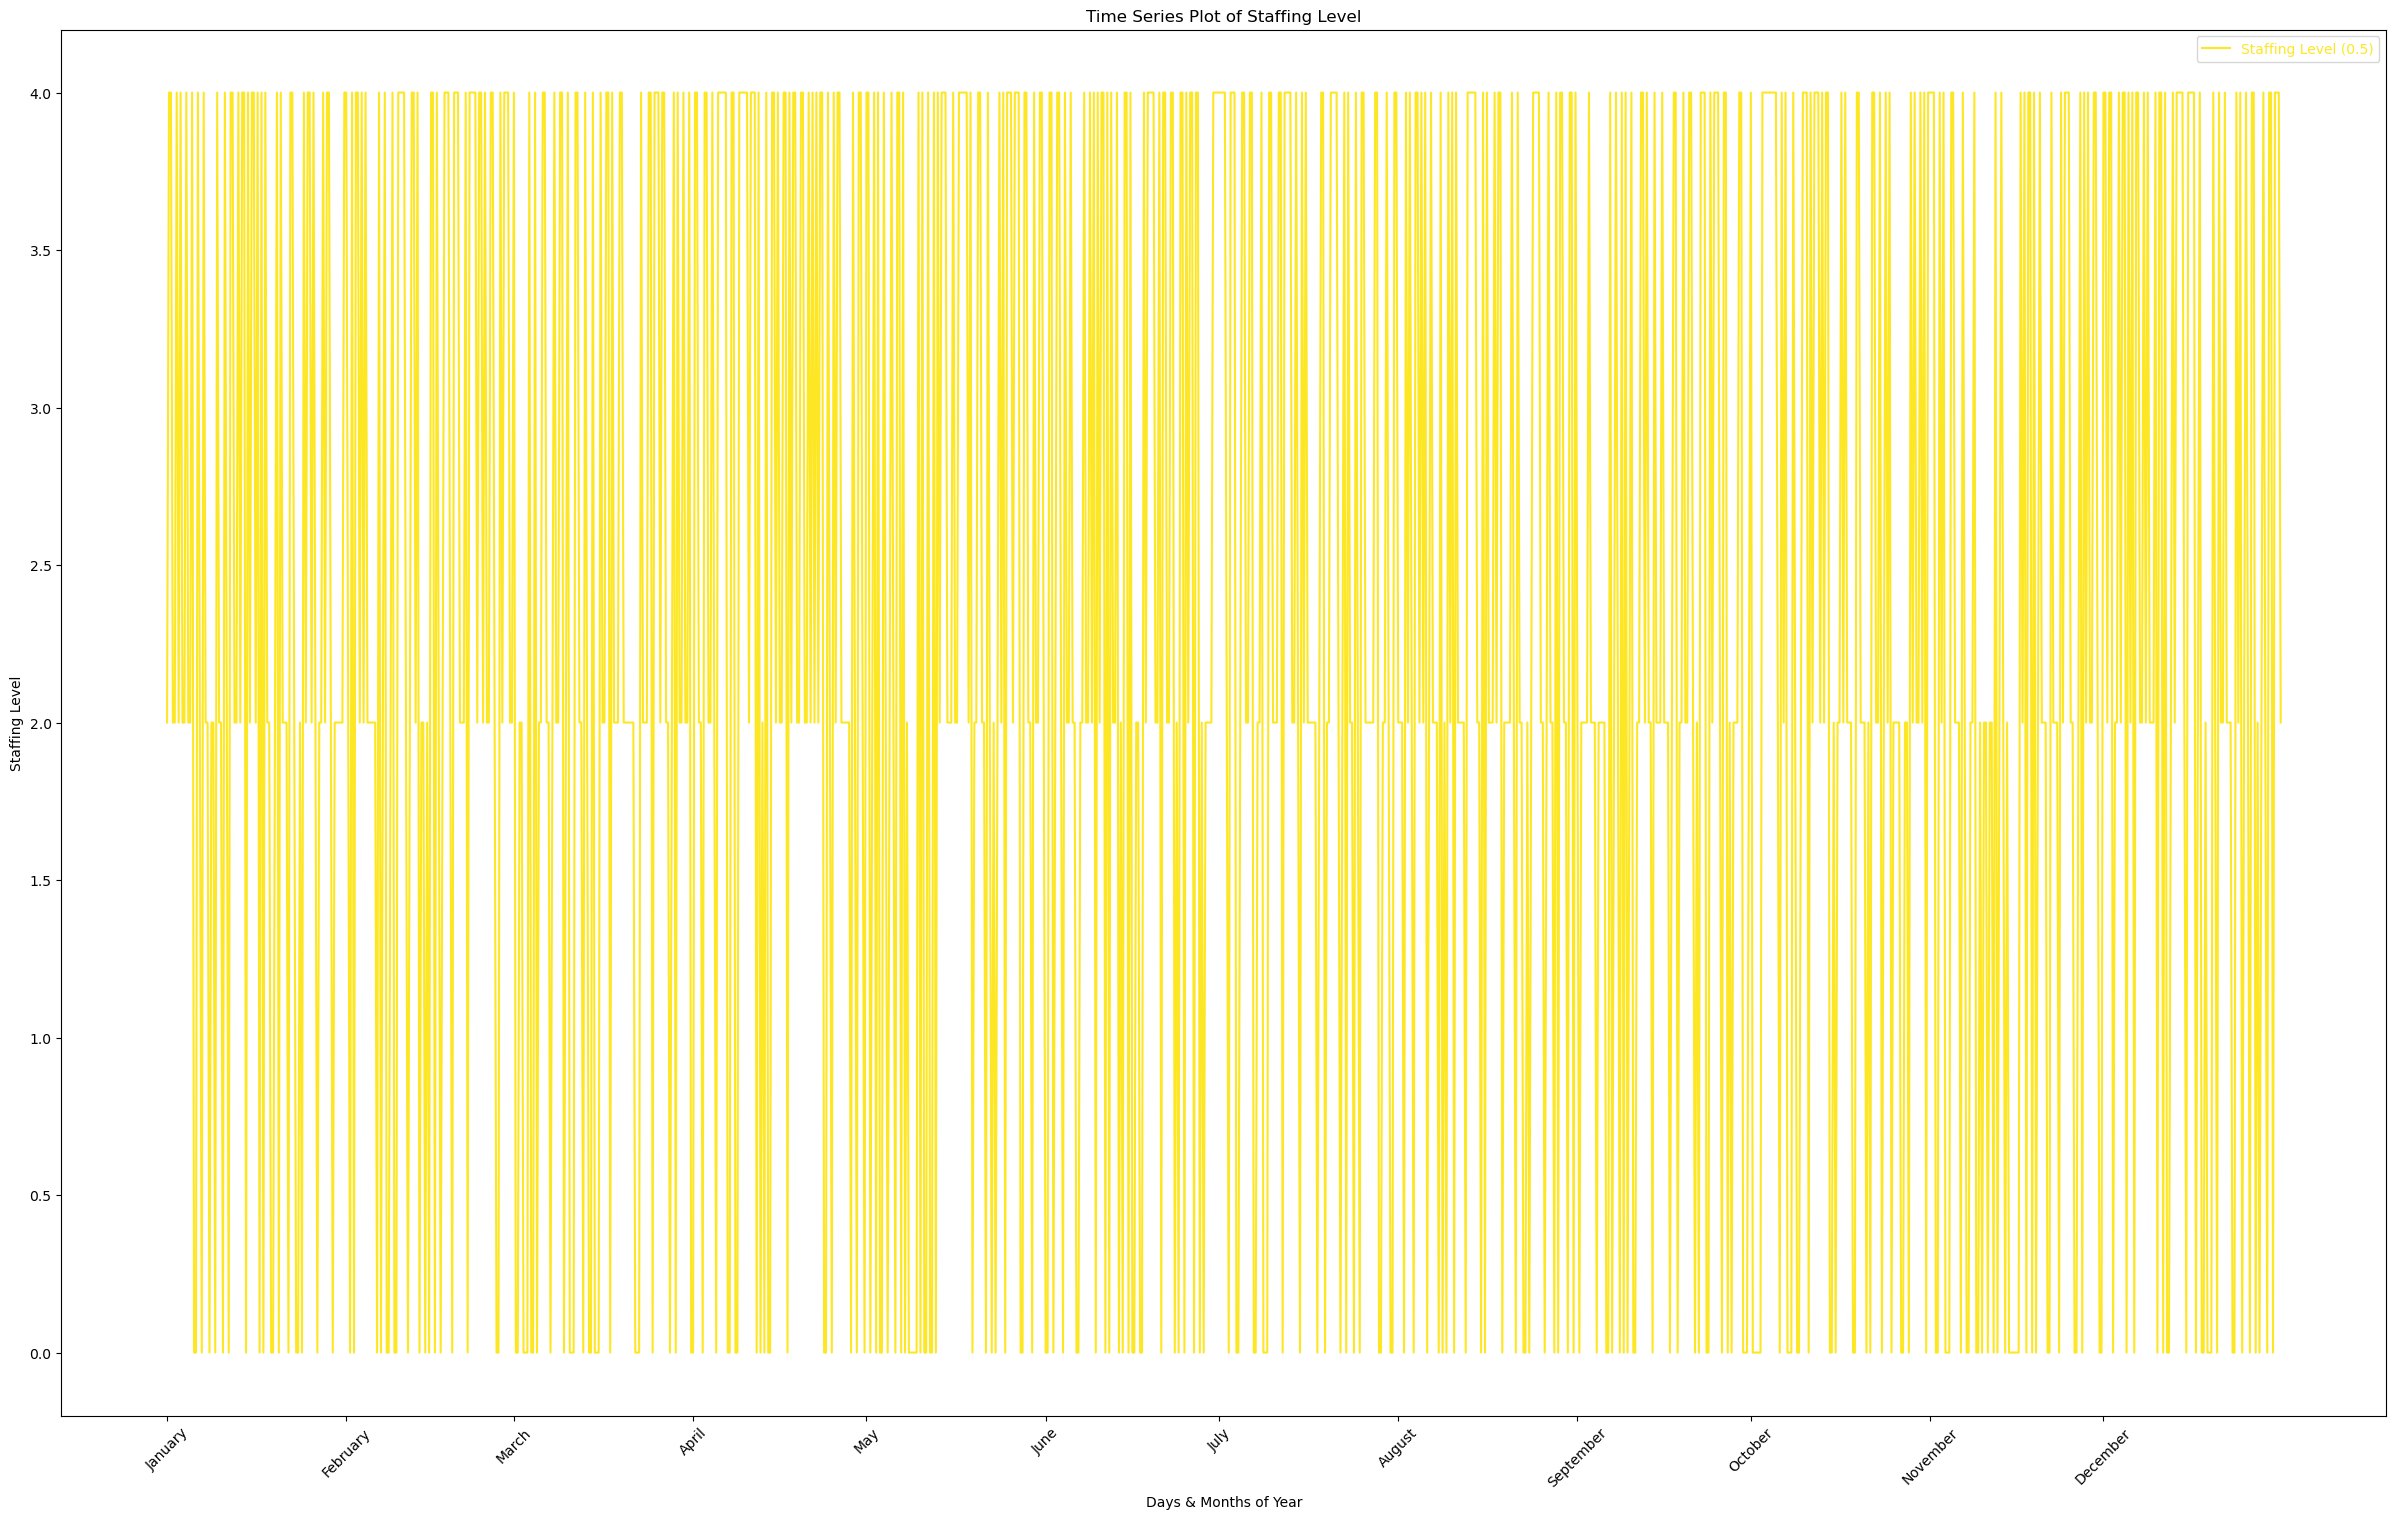

In [5]:
display(staffing_levels)
month = 'All'
observed_kpi = 'Staffing Level'
aggregation_level = 'year'
handling_times = [0.5]
sim.create_staffing_levels_average_week_plot(staffing_levels=staffing_levels,
                                             month=month, 
                                             observed_kpi=observed_kpi, 
                                             handling_times=handling_times)

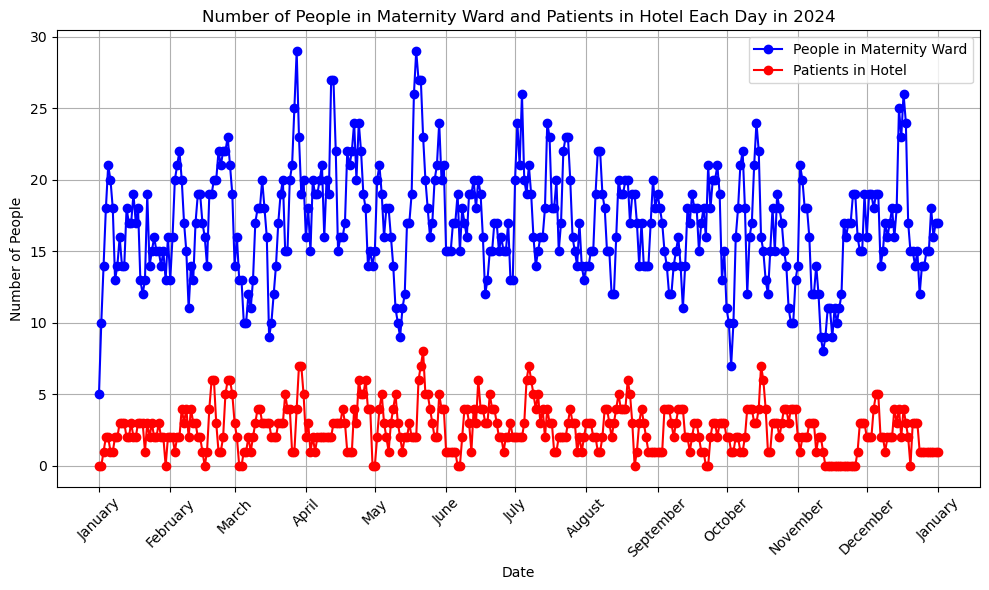

In [6]:
# Define parameters for length of stay
length_of_stay_prob = {
    1: 0.10,  # 10% for 1 day
    2: 0.20,  # 20% for 2 days
    3: 0.25,  # 25% for 3 days
    4: 0.35,  # 35% for 4 days
    5: 0.05,  # 5% for 5 days
    6: 0.05   # 5% for 6 days
}

date_range = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
date_range = date_range.strftime('%Y-%m-%d')


# Simulate number of people in maternity ward each day
num_people_in_ward = []
patients_in_ward = []
num_people_in_hotel = []
patients_in_hotel = []

for day in date_range:
    if len(num_people_in_hotel) > 0:
        num_people_in_hotel = [duration - 1 for duration in num_people_in_hotel if duration != 0]
    for patient in [patient for patient in patients_in_ward if patient == 1]:
        if np.random.rand() < 0.2:
            num_people_in_hotel.append(2)
    patients_in_hotel.append(len(num_people_in_hotel))
    if len(patients_in_ward) > 0:
        patients_in_ward = [duration - 1 for duration in patients_in_ward if duration != 0]
    daily_demand = staffing_levels.loc[day]['Number of surgeries (0.5)'].sum()
    stay_durations = sim.simulate_length_of_stay(daily_demand, length_of_stay_prob)
    num_people_in_ward.append(daily_demand + len(patients_in_ward))
    for duration in stay_durations:
        patients_in_ward.append(duration)

plt.figure(figsize=(10, 6))
plt.plot(date_range, num_people_in_ward, marker='o', color='b', linestyle='-', label='People in Maternity Ward')
plt.plot(date_range, patients_in_hotel, marker='o', color='r', linestyle='-', label='Patients in Hotel')
plt.title('Number of People in Maternity Ward and Patients in Hotel Each Day in 2024')
plt.xlabel('Date')
plt.ylabel('Number of People')
plt.grid(True)

#  Format x-axis ticks to show only the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))  # %B for full month name
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()



## M/M/1 Queuing for Staffing in Ward and Hotel

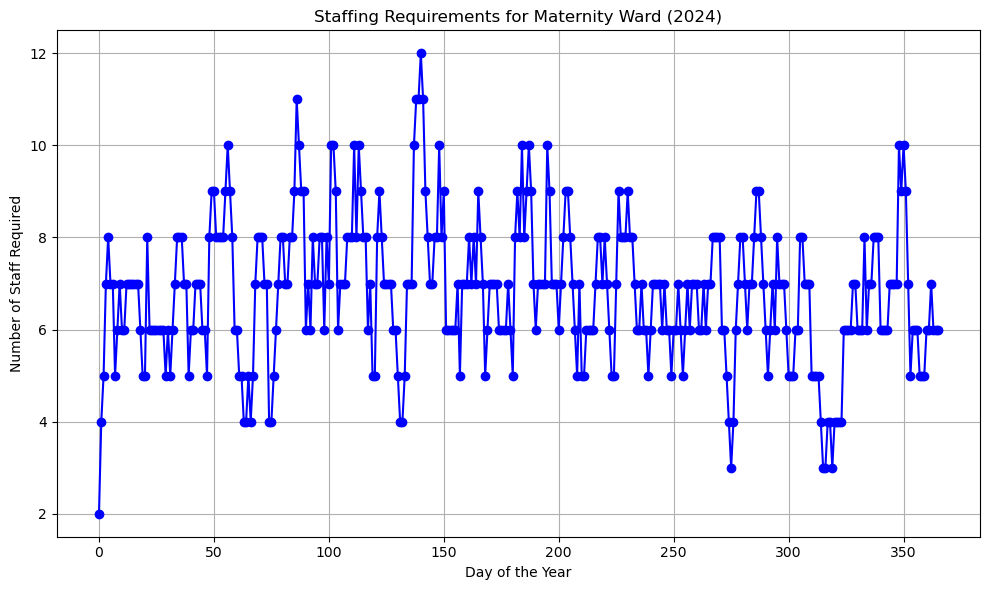

In [7]:
# Define simulation parameters
num_days = 366
day = 0
daily_hotel_ward = []
for row in num_people_in_ward:
    daily_hotel_ward.append(row + patients_in_hotel[day])
    day +=1

daily_patient_load = daily_hotel_ward 
patient_to_staff_ratio = 3
shift_length_hours = 8
num_shifts_per_day = 3
service_time_mean = 1

# Simulate staffing requirements for each day
num_staff_required = [np.ceil(patients / patient_to_staff_ratio) for patients in daily_patient_load]

# Plot staffing requirements
plt.figure(figsize=(10, 6))
plt.plot(num_staff_required, marker='o', color='b', linestyle='-')
plt.title('Staffing Requirements for Maternity Ward (2024)')
plt.xlabel('Day of the Year')
plt.ylabel('Number of Staff Required')
plt.grid(True)
plt.tight_layout()
plt.show()


## Erlang-C for Staffing

,Number of surgeries,Raw Staffing Level,Staffing Level,Service Level (%),Occupancy (%),Waiting Probability (%)
0,5,4,5,99.99,5.21,0.01
1,10,4,5,99.91,10.42,0.09
2,15,5,6,99.95,12.50,0.05
3,20,6,7,99.98,13.89,0.02
4,23,6,7,99.95,15.97,0.05
...,...,...,...,...,...,...
361,16,5,6,99.94,13.33,0.07
362,19,6,7,99.98,13.19,0.02
363,17,5,6,99.92,14.17,0.09
364,18,6,7,99.99,12.50,0.01


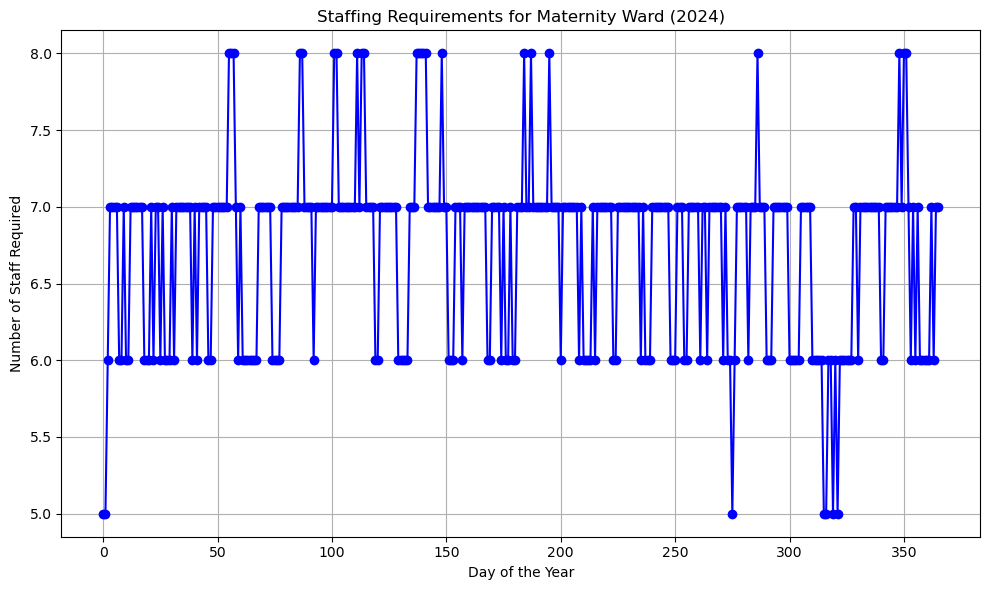

In [8]:
# Define simulation parameters
num_days = 366
day = 0
daily_hotel_ward = []
for row in num_people_in_ward:
    daily_hotel_ward.append(row + patients_in_hotel[day])
    day +=1


params = {"service_level" : [0.999],
        "shrinkage" :       [0.1],
        "max_occupancy" :   [1.0],
        "asa" :             [0.01],
        "aht":              [1],
        'interval':         [24]}

interval = value = params['interval']
service_level = value= params["service_level"]
asa = value = params["asa"]
aht = value = params["aht"]
shrinkage = value = params["shrinkage"]
max_occupancy = value = params["max_occupancy"]
demand = daily_hotel_ward
demand = pd.Series(demand)


staffing_level_nurses = sim.compute_staffing_levels(demand = demand,
                                                aht = aht,
                                                asa=asa,
                                                interval=interval,
                                                shrinkage=shrinkage,
                                                service_level=service_level,
                                                max_occupancy=max_occupancy)

display(staffing_level_nurses)
# Plot staffing requirements
plt.figure(figsize=(10, 6))
plt.plot(staffing_level_nurses['Staffing Level'], marker='o', color='b', linestyle='-')
plt.title('Staffing Requirements for Maternity Ward (2024)')
plt.xlabel('Day of the Year')
plt.ylabel('Number of Staff Required')
plt.grid(True)
plt.tight_layout()
plt.show()


## Optimization for Staffing

In [9]:
shift_index = []

for nurse in range(1,(len(list(staffing_level_nurses.index.values))*3)+1):
    shift_index.append(nurse)

shift_demand = []

for patient in daily_hotel_ward:
    shift_demand.append(patient)
    shift_demand.append(patient)
    shift_demand.append(patient)


In [10]:
df_index = shift_index
demand = shift_demand
MaxStaff = 40
PPS = 4
availability = 40
ServiceLevel = 0.8

In [11]:
model = opt.labor_scheduling(df_index, demand, MaxStaff, PPS, availability, ServiceLevel)

In [12]:
result, status, obj, staff_allocated = opt.optimize_staffing(model)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\Consumer\AppData\Local\Temp\tmpjguvcr3a.glpk.raw --wglp
 C:\Users\Consumer\AppData\Local\Temp\tmp22spz_84.glpk.glp --cpxlp C:\Users\Consumer\AppData\Local\Temp\tmp1dio2k_g.pyomo.lp
Reading problem data from 'C:\Users\Consumer\AppData\Local\Temp\tmp1dio2k_g.pyomo.lp'...
3294 rows, 1098 columns, 3294 non-zeros
1098 integer variables, none of which are binary
16480 lines were read
Writing problem data to 'C:\Users\Consumer\AppData\Local\Temp\tmp22spz_84.glpk.glp'...
13179 lines were written
GLPK Integer Optimizer 5.0
3294 rows, 1098 columns, 3294 non-zeros
1098 integer variables, none of which are binary
Preprocessing...
Objective value =   4.707000000e+03
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 1.6 Mb (1693428 bytes)
Writing MIP solution to 'C:\Users\Consumer\AppData\Local\Temp\tmpjguvcr3a.glpk.raw'...
4401 lines were written


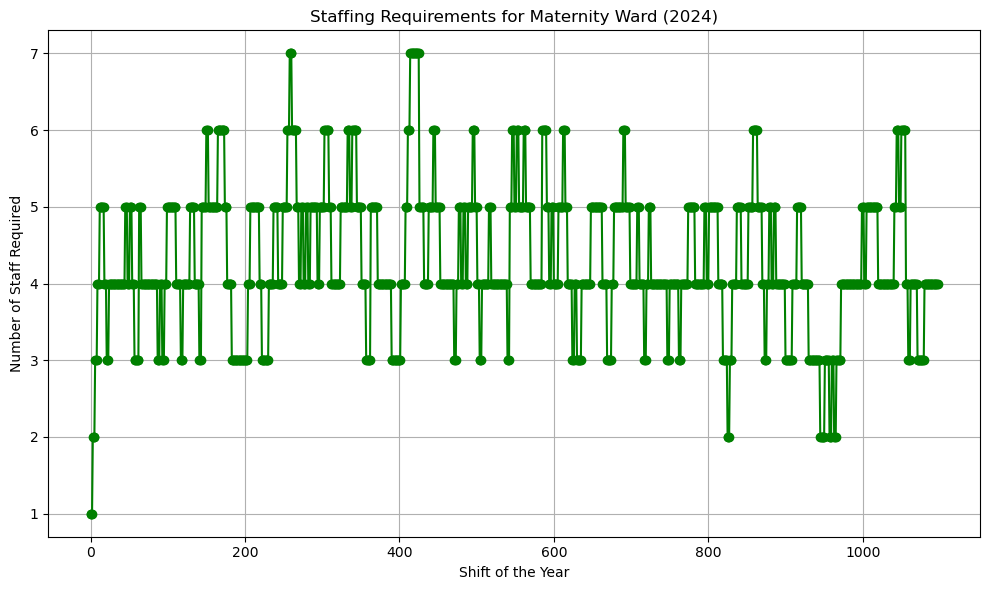

In [13]:
# Plot staffing requirements
plt.figure(figsize=(10, 6))
plt.plot(staff_allocated, marker='o', color='g', linestyle='-')
plt.title('Staffing Requirements for Maternity Ward (2024)')
plt.xlabel('Shift of the Year')
plt.ylabel('Number of Staff Required')
plt.grid(True)
plt.tight_layout()
plt.show()

## Total Employees Needed